# import

In [1]:
import os
import time
import exrex
import random
import pickle
import numpy as np
import pandas as pd
from math import ceil
from faker import Faker
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from scipy.interpolate import interp1d
from scipy.stats import kstest, ks_2samp, chi2_contingency, wasserstein_distance, norm
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from sdv.metadata import MultiTableMetadata
from rdt import HyperTransformer

In [2]:
fake = Faker('en-NZ')

In [3]:
set_verbosity(ERROR)

# load data

In [4]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [5]:
real_data_collection = load_data_collection("gtfs")

In [6]:
del real_data_collection['shapes']

# Preprocessing

In [7]:
def adjust_time(df, datetime_cols):
    for col in datetime_cols:
        df[col] = pd.to_timedelta(df[col])
        df[col] = df[col] % pd.Timedelta(days=1)
        df[col] = df[col].astype(str).str.split().str[-1]
    return df

In [8]:
sdv_metadata = MultiTableMetadata()

In [9]:
columns_to_remove = ['agency_fare_url', 'agency_email']
real_data_collection['agency'].drop(columns_to_remove, axis=1, inplace=True)

In [10]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id',regex_format='[A-Z]{3,5}')
sdv_metadata.update_column(table_name='agency',column_name='agency_name',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

In [11]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id',regex_format='[A-Z][a-zA-Z]{2,7}-[0-9]{2}')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='boolean')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

In [12]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id',regex_format='[A-Z][a-zA-Z]{2,7}-[0-9]{2}')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

In [13]:
columns_to_remove = ['route_desc', 'route_url','route_sort_order']
real_data_collection['routes'].drop(columns_to_remove, axis=1, inplace=True)

In [14]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id',regex_format='([A-Z]{3,4}|[0-9]{3,4})-[0-9]{3}')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id',regex_format='[A-Z]{3,5}')
sdv_metadata.update_column(table_name='routes',column_name='route_short_name',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_long_name',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id',regex_format='([A-Z]{2,6}|[0-9]{2,6})')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

In [15]:
columns_to_remove = ['stop_desc', 'zone_id','stop_url','stop_timezone']
real_data_collection['stops'].drop(columns_to_remove, axis=1, inplace=True)

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id',regex_format='[0-9]{2,6}-[a-z0-9]{8}')
sdv_metadata.update_column(table_name='stops',column_name='stop_code',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stops',column_name='stop_name',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='boolean')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

In [17]:
real_data_collection['stop_times'] = adjust_time(real_data_collection['stop_times'], ['arrival_time','departure_time'])

In [18]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id',regex_format='[0-9]{4}-[0-9]{5}-[0-9]{5}-[0-9]{1}-[a-z0-9]{8}')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id',regex_format='[0-9]{2,6}-[a-z0-9]{8}')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='numerical',computer_representation='Int32')

In [19]:
columns_to_remove = ['trip_short_name', 'block_id']
real_data_collection['trips'].drop(columns_to_remove, axis=1, inplace=True)

In [20]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id',regex_format='([A-Z]{3,4}|[0-9]{3,4})-[0-9]{3}')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id',regex_format='[A-Z][a-zA-Z]{2,7}-[0-9]{2}')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id',regex_format='[0-9]{4}-[0-9]{5}-[0-9]{5}-[0-9]{1}-[a-z0-9]{8}')
sdv_metadata.update_column(table_name='trips',column_name='trip_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id',regex_format='[0-9]{4}-[0-9]{5}-[a-z0-9]{8}')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='boolean')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='boolean')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

In [21]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

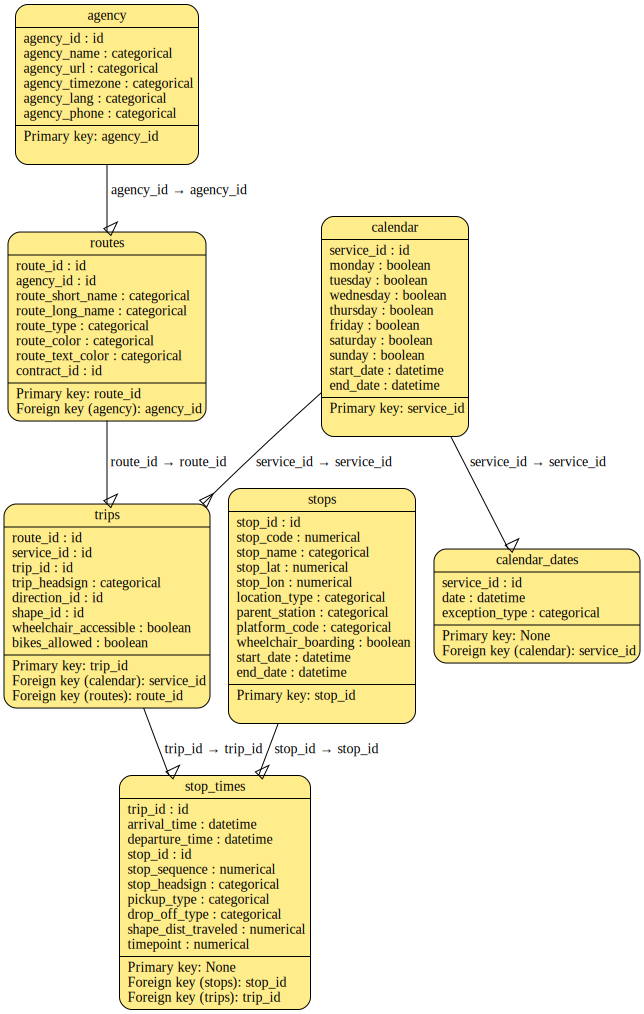

In [22]:
sdv_metadata.visualize()

In [23]:
def sdvmetadata_to_modelmetadata(sdv_metadata):
    new_format = {}
    for table_name, table_info in sdv_metadata["tables"].items():
        new_format[table_name] = {
            "primary_key": table_info.get("primary_key"),
            "parent": {},
            "child": {},
            "is_sequential": False,
            "sort_order":None,
            "additional_key": None,
        }
    for relationship in sdv_metadata["relationships"]:
        parent_table = relationship["parent_table_name"]
        child_table = relationship["child_table_name"]
        foreign_key = relationship["child_foreign_key"]
        new_format[child_table]["parent"][parent_table] = foreign_key
        new_format[parent_table]["child"][child_table] = foreign_key
    return new_format

In [24]:
def create_formatter_collection(data_collection):
    formatter_collection = {}
    for df_name, df in data_collection.items():
        ht = HyperTransformer()
        ht.detect_initial_config(df)
        ht.update_transformers_by_sdtype(
            sdtype='categorical',
            transformer_name='LabelEncoder'
        )
        ht.update_transformers_by_sdtype(
            sdtype='datetime',
            transformer_name='OptimizedTimestampEncoder'
        )
        ht.update_transformers_by_sdtype(
            sdtype='numerical',
            transformer_name='FloatFormatter'
        )
        ht.fit(df)
        formatter_collection[df_name] = ht
    return formatter_collection

In [25]:
def batch_transform(modelling_metadata, df_dict, ht_dict):
    # Initialize the dictionary that will store the mappings for each primary key
    primary_key_dict = {}

    # Initialize a new dictionary to store the transformed dataframes
    transformed_df_dict = {table: df.copy() for table, df in df_dict.items()}

    # Initialize the dictionary to store transform methods
    transform_method_dict = {table: {'labels': [], 'table': []} for table in df_dict.keys()}

    # First pass: Fit the HT objects for all tables
    for table_name, table_info in modelling_metadata.items():
        ht = ht_dict[table_name]
        ht.fit(transformed_df_dict[table_name])  # Fit the HT object on the entire table

    # Second pass: factorize primary keys and build the global primary key dictionary
    for table_name, table_info in modelling_metadata.items():
        primary_key = table_info['primary_key']
        if primary_key is not None:  # Skip tables without a primary key
            transformed_df_dict[table_name][primary_key], unique = pd.factorize(transformed_df_dict[table_name][primary_key])
            primary_key_dict[table_name] = {primary_key: {key: value for value, key in enumerate(unique)}}
            transform_method_dict[table_name]['labels'].append(primary_key)

    # Third pass: replace foreign keys using the primary key dictionary
    for table_name, table_info in modelling_metadata.items():
        for parent_table, foreign_key in table_info['parent'].items():
            primary_key = modelling_metadata[parent_table]['primary_key']
            transformed_df_dict[table_name][foreign_key] = transformed_df_dict[table_name][foreign_key].map(primary_key_dict[parent_table][primary_key])
            transform_method_dict[table_name]['labels'].append(foreign_key)

    # Fourth pass: transform the remaining columns with the fitted HT objects
    for table_name, table_info in modelling_metadata.items():
        ht = ht_dict[table_name]
        df = transformed_df_dict[table_name]
        remaining_cols = [col for col in df.columns if col not in transform_method_dict[table_name]['labels']]
        if remaining_cols:
            df[remaining_cols] = ht.transform_subset(df[remaining_cols])  # Transform only the remaining columns
            transform_method_dict[table_name]['table'].extend(remaining_cols)

    return transformed_df_dict, transform_method_dict

In [26]:
modelling_metadata = sdvmetadata_to_modelmetadata(sdv_metadata.to_dict())

In [27]:
modelling_metadata['calendar_dates']['is_sequential']=True
modelling_metadata['calendar_dates']['sort_order']=['service_id']
modelling_metadata['stop_times']['is_sequential']=True
modelling_metadata['stop_times']['sort_order']=['trip_id']

In [28]:
%%time
formatter_collections = create_formatter_collection(real_data_collection)

C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no longer supported. Imputing with the 'mean' instead.
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no longer supported. Imputing with the 'mean' instead.
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no longer supported. Imputing with the 'mean' instead.
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no longer supported. Imputing with the 'mean' instead.
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no long

CPU times: total: 3.42 s
Wall time: 3.43 s


C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\transformers\base.py:109: FutureWarning: Setting 'missing_value_replacement' to 'None' is no longer supported. Imputing with the 'mean' instead.
  warnings.warn(


In [29]:
%%time
transformed_data_collection, transform_method_dict = batch_transform(modelling_metadata, real_data_collection, formatter_collections)

CPU times: total: 5 s
Wall time: 5 s


## Rank Columns By Correlation

In [30]:
def rank_columns_by_correlation(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Calculate the average absolute correlation of each column with all other columns
    avg_corr = corr_matrix.mean()

    # Sort by average correlation
    avg_corr = avg_corr.sort_values(ascending=False)

    # Return the dictionary of column names and their average absolute correlation
    return avg_corr.to_dict()

In [31]:
# def add_cor_ranked_columns(data_collection, modelling_metadata):
#     for df_name, df in data_collection.items():
#         modelling_metadata[df_name]['correlation'] = rank_columns_by_correlation(df)

In [32]:
# def identify_columns(data_collection, modelling_metadata):
#     for df_name, df in data_collection.items():
#         continuous_cols = []
#         discrete_cols = []
#         df_cols = df.columns.tolist()
#         for col in df_cols:
#             if df[col].dtype == np.float64:
#                 if all(df[col] % 1 == 0):
#                     discrete_cols.append(col)
#                 else:
#                     continuous_cols.append(col)
#             elif df[col].dtype == np.int64:
#                 discrete_cols.append(col)
#         modelling_metadata[df_name]['numeric_types'] = {'continuous': continuous_cols, 'discrete': discrete_cols}

In [33]:
# identify_columns(transformed_data_collection, modelling_metadata)

## Obtain Foreign Key Distribution

In [34]:
def identify_trended_columns(data_collection, modelling_metadata, lab_tab_ratio=None, cor_th=0.5):
    for df_name, content in modelling_metadata.items():
        foreign_columns = []
        label_columns = []
        selected_columns = []
        if content['parent'] != {}:
            foreign_columns = list(modelling_metadata[df_name]['parent'].values())
        ranked_columns = rank_columns_by_correlation(data_collection[df_name])
        if content['primary_key'] != None:
            if lab_tab_ratio != None and cor_th == None:
                ranked_columns = [col for col in list(ranked_columns.keys()) if col != content['primary_key']]
                selected_columns = ranked_columns[:ceil(len(ranked_columns)*lab_tab_ratio)]
            elif lab_tab_ratio == None and cor_th != None:
                selected_columns = [col for col,cor in ranked_columns.items() if cor >= cor_th and col != content['primary_key']]
            else:
                selected_columns = []
        selected_columns = list(set(foreign_columns) | set(selected_columns))
        if selected_columns != [] or None:
            modelling_metadata[df_name]['selected_columns'] = selected_columns
        else:
            modelling_metadata[df_name]['selected_columns'] = []

In [35]:
# def split_continuous_discrete(data_collection, modelling_metadata, lab_tab_ratio=None, cor_th=0.75):
#     for df_name, content in modelling_metadata.items():
#         foreign_columns = []
#         label_columns = []
#         selected_columns = []
#         if content['parent'] != {}:
#             foreign_columns = list(modelling_metadata[df_name]['parent'].values())
#         discrete_columns = modelling_metadata[df_name]['numeric_types']['discrete']
#         if content['primary_key'] != None:
#             selected_columns = [col for col in discrete_columns if col != content['primary_key']]
#         selected_columns = list(set(foreign_columns) | set(selected_columns))
#         if selected_columns != [] or None:
#             modelling_metadata[df_name]['selected_columns'] = selected_columns
#         else:
#             modelling_metadata[df_name]['selected_columns'] = []

In [36]:
identify_trended_columns(transformed_data_collection, modelling_metadata, lab_tab_ratio=None, cor_th=0.5)

## Scaling

In [37]:
def minmax_scaling(df, min_=0, max_=1):
    scaler = MinMaxScaler((min_,max_))
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [38]:
def normal_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [39]:
# def extract_key_and_scaled_features(df, label_columns):
#     labels = df[label_columns]
#     table = df.drop(columns=label_columns)
#     table_column_names = table.columns
#     scaled_table, table_scaler = normal_scaling(table)
#     scaled_labels, labels_scaler = normal_scaling(labels)
#     return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [40]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    try:
        scaled_table, table_scaler = normal_scaling(table)
    except:
        scaled_table = None
        table_scaler = None
    scaled_labels, labels_scaler = normal_scaling(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [41]:
def batch_scaling(data_collection, modelling_metadata):
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        primary_key_column = modelling_metadata[df_name]['primary_key']
        if primary_key_column != None:
            label_columns = list(set([primary_key_column]) | set(selected_columns))
            primary_key_scaler = StandardScaler()
            primary_key_scaler = StandardScaler().fit(df[[primary_key_column]])
        else:
            label_columns = selected_columns
            primary_key_scaler = None
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels}
        backtransformation_dict[df_name] = {'table_scaler':table_scaler,
                                            'labels_scaler':labels_scaler,
                                            'primary_key_scaler':primary_key_scaler,
                                       'table_col_names':table_columns,
                                       'labels_col_names':label_columns,
                                       'col_names':df.columns,
                                           'unique_elements':unique_elements(df[label_columns])}
    return processed_data_collection, backtransformation_dict

In [42]:
def unique_elements(data):
    unique_counts = data.nunique()
    unique_dict = unique_counts.to_dict()
    return unique_dict

In [43]:
def fit_kde(data, kernel='tophat', bandwidth='scott', leaf_size=64):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth, leaf_size=leaf_size)
    kde.fit(data)
    unique_elements_dict = unique_elements(data)
    return kde, unique_elements_dict

In [44]:
def batch_kde_fitting(processed_data_collection, modelling_metadata):
    kde_collection = {}
    for df_name, content in processed_data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        if selected_columns != []:
            kde, unique_elements = fit_kde(content['labels'][modelling_metadata[df_name]['selected_columns']])
            kde_collection[df_name] = kde
    return kde_collection

In [45]:
processed_data_collection, backtransformation_dict = batch_scaling(transformed_data_collection, modelling_metadata)

In [46]:
kde_collection = batch_kde_fitting(processed_data_collection, modelling_metadata)

# Main GAN Algorithm

## Additional Custom Function (Wasserstein Loss) (\*Scrapped\*)

In [47]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [48]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [49]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, critic_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(critic_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, critic

In [50]:
def build_generator(table_dim, labels_dim, latent_dim=100):
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1DTranspose(64,kernel_size=9,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=9,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(256,kernel_size=9,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(512,kernel_size=9,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    output_layer = layers.Dense(table_dim, activation='linear',kernel_initializer='glorot_normal')(flatten_layer)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [51]:
def build_critic(table_dim, labels_dim, weight_threshold=0.01, optimization_rate=0.00005):
    opt = optimizers.Adam(optimization_rate)
    clip = ClipConstraint(weight_threshold)
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1D(512,kernel_size=9,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same',kernel_constraint=clip)(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1D(256,kernel_size=9,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same',kernel_constraint=clip)(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=9,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same',kernel_constraint=clip)(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1D(64,kernel_size=9,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same',kernel_constraint=clip)(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    # dropout = layers.Dropout(0.2)(flatten_layer)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='glorot_normal')(flatten_layer)
    critic = models.Model([table_input, labels_input], output_layer)
    critic.compile(loss=wasserstein_loss, optimizer=opt)
    return critic

## Build GAN

In [52]:
def build_gan(generator, critic, optimization_rate=0.00005):
    critic.trainable = False
    opt = optimizers.Adam(optimization_rate)
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    critic_output = critic([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=critic_output)
    gan.compile(optimizer=opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [53]:
def train_individual_gan(name, real_table, real_labels, n_critic=3, epochs=50, batch_size=400, latent_dim=100, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1* np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        # train critic:
        for _ in range(n_critic):
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            x_real_labels = real_labels.iloc[idx]
            x_real_table = real_table.iloc[idx]
            x_fake_table = generator.predict([noise, x_real_labels])
            c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake = critic.train_on_batch([x_fake_table, x_real_labels], y_fake)
            c_loss.append(np.mean(c_loss_fake)-np.mean(c_loss_real))
            rand_seed += 1
            
        c_loss = np.mean(c_loss)
        # train generator/GAN
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        x_real_labels = real_labels.iloc[idx]
        x_gan = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch([x_gan, x_real_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if (epoch+1) % 10 == 0 or epoch in [0,epochs-1]:
            print(f"[Epoch: {epoch+1}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [54]:
def train_individual_sequential_gan(name, real_table, real_labels, sort_order, n_critic=3, epochs=50, batch_size=400, latent_dim=100, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    samp_size = min(batch_size, real_table.shape[0])
    half_samp_size = min(half_batch, real_table.shape[0])
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for _ in range(n_critic):
            idx = random.randint(0, real_table.shape[0]-half_samp_size)
            noise = np.random.normal(0, 1, (half_samp_size, latent_dim))
            x_real_labels = real_labels.iloc[idx:(idx+half_samp_size)]
            x_real_table = real_table.iloc[idx:(idx + half_samp_size)]
            x_fake_table = generator.predict([noise, x_real_labels])
            c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake = critic.train_on_batch([x_fake_table, x_real_labels], y_fake)
            c_loss.append(np.mean(c_loss_fake)-np.mean(c_loss_real))
            rand_seed += 1
        c_loss = np.mean(c_loss)
        
        # train generator/GAN
        x_gan = np.random.normal(0, 1, (samp_size, latent_dim))
        idx = random.randint(0, real_table.shape[0]-samp_size)
        x_real_labels = real_labels.iloc[idx:(idx+samp_size)]
        g_loss = gan.train_on_batch([x_gan, x_real_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if (epoch+1) % 10 == 0 or epoch in [0,epochs-1]:
            print(f"[Epoch: {epoch+1}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [55]:
def collection_training(processed_collection, modelling_metadata, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        latent_dim = 100
        if content['table'] is not None:
            if modelling_metadata[df_name]['is_sequential'] == True:
                generator_log, critic_log = train_individual_sequential_gan(df_name,
                                                                            content['table'],
                                                                            content['labels'],
                                                                            modelling_metadata[df_name]['sort_order'],
                                                                            epochs=training_parameter_dict[df_name]['epochs'],
                                                                            latent_dim = latent_dim,
                                                                            return_logs=True)
            else:
                generator_log, critic_log = train_individual_gan(df_name,
                                                                 content['table'],
                                                                 content['labels'],
                                                                 epochs=training_parameter_dict[df_name]['epochs'],
                                                                 latent_dim = latent_dim,
                                                                 return_logs=True)
            logs.append([df_name, generator_log, critic_log])
            in_loop_elapsed_time = time.time() - start_time
            minutes, seconds = divmod(in_loop_elapsed_time, 60)
            print("Time Used: %dm %ds" % (minutes, seconds))
            print('.')
            print('.')
        else:
            print("Skipped (Fully-Discrete Table)")
            print('.')
            print('.')
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [56]:
def calculate_epochs(data_collection, batch_size=400):
    parameter_dict = {}
    for df_name, df in data_collection.items():
        epochs = len(df) / batch_size
        if epochs < 5:
            epochs = 5
        elif epochs > 500:
            epochs = 500
        parameter_dict[df_name] = {'epochs':round(epochs)}
    return parameter_dict

In [57]:
training_parameter_dict = calculate_epochs(transformed_data_collection)

In [58]:
# training_parameter_dict = {'agency': {'epochs': 10},
#                            'calendar': {'epochs': 10},
#                            'calendar_dates': {'epochs': 10},
#                            'routes': {'epochs': 10},
#                            'stops': {'epochs': 10},
#                            'stop_times': {'epochs': 10},
#                            'trips': {'epochs': 10}}

In [59]:
training_parameter_dict

{'agency': {'epochs': 5},
 'calendar': {'epochs': 5},
 'calendar_dates': {'epochs': 5},
 'routes': {'epochs': 5},
 'stops': {'epochs': 17},
 'stop_times': {'epochs': 500},
 'trips': {'epochs': 81}}

Learning "agency" data......
[Epoch: 1] [C loss: 0.001] [G loss: -0.002] [Speed: 0.15 it/s]
[Epoch: 5] [C loss: 0.002] [G loss: -0.008] [Speed: 4.06 it/s]
Time Used: 0m 8s
.
.
Learning "calendar" data......
[Epoch: 1] [C loss: 0.001] [G loss: 0.002] [Speed: 0.29 it/s]
[Epoch: 5] [C loss: 0.002] [G loss: 0.007] [Speed: 3.74 it/s]
Time Used: 0m 4s
.
.
Learning "calendar_dates" data......
[Epoch: 1] [C loss: 0.001] [G loss: -0.002] [Speed: 0.28 it/s]
[Epoch: 5] [C loss: 0.002] [G loss: -0.005] [Speed: 3.92 it/s]
Time Used: 0m 4s
.
.
Learning "routes" data......
[Epoch: 1] [C loss: 0.001] [G loss: -0.003] [Speed: 0.29 it/s]
[Epoch: 5] [C loss: 0.002] [G loss: -0.012] [Speed: 3.82 it/s]
Time Used: 0m 4s
.
.
Learning "stops" data......
[Epoch: 1] [C loss: 0.001] [G loss: 0.002] [Speed: 0.3 it/s]
[Epoch: 10] [C loss: 0.002] [G loss: 0.006] [Speed: 3.46 it/s]
[Epoch: 17] [C loss: 0.002] [G loss: 0.01] [Speed: 2.78 it/s]
Time Used: 0m 8s
.
.
Learning "stop_times" data......
[Epoch: 1] [C loss: 

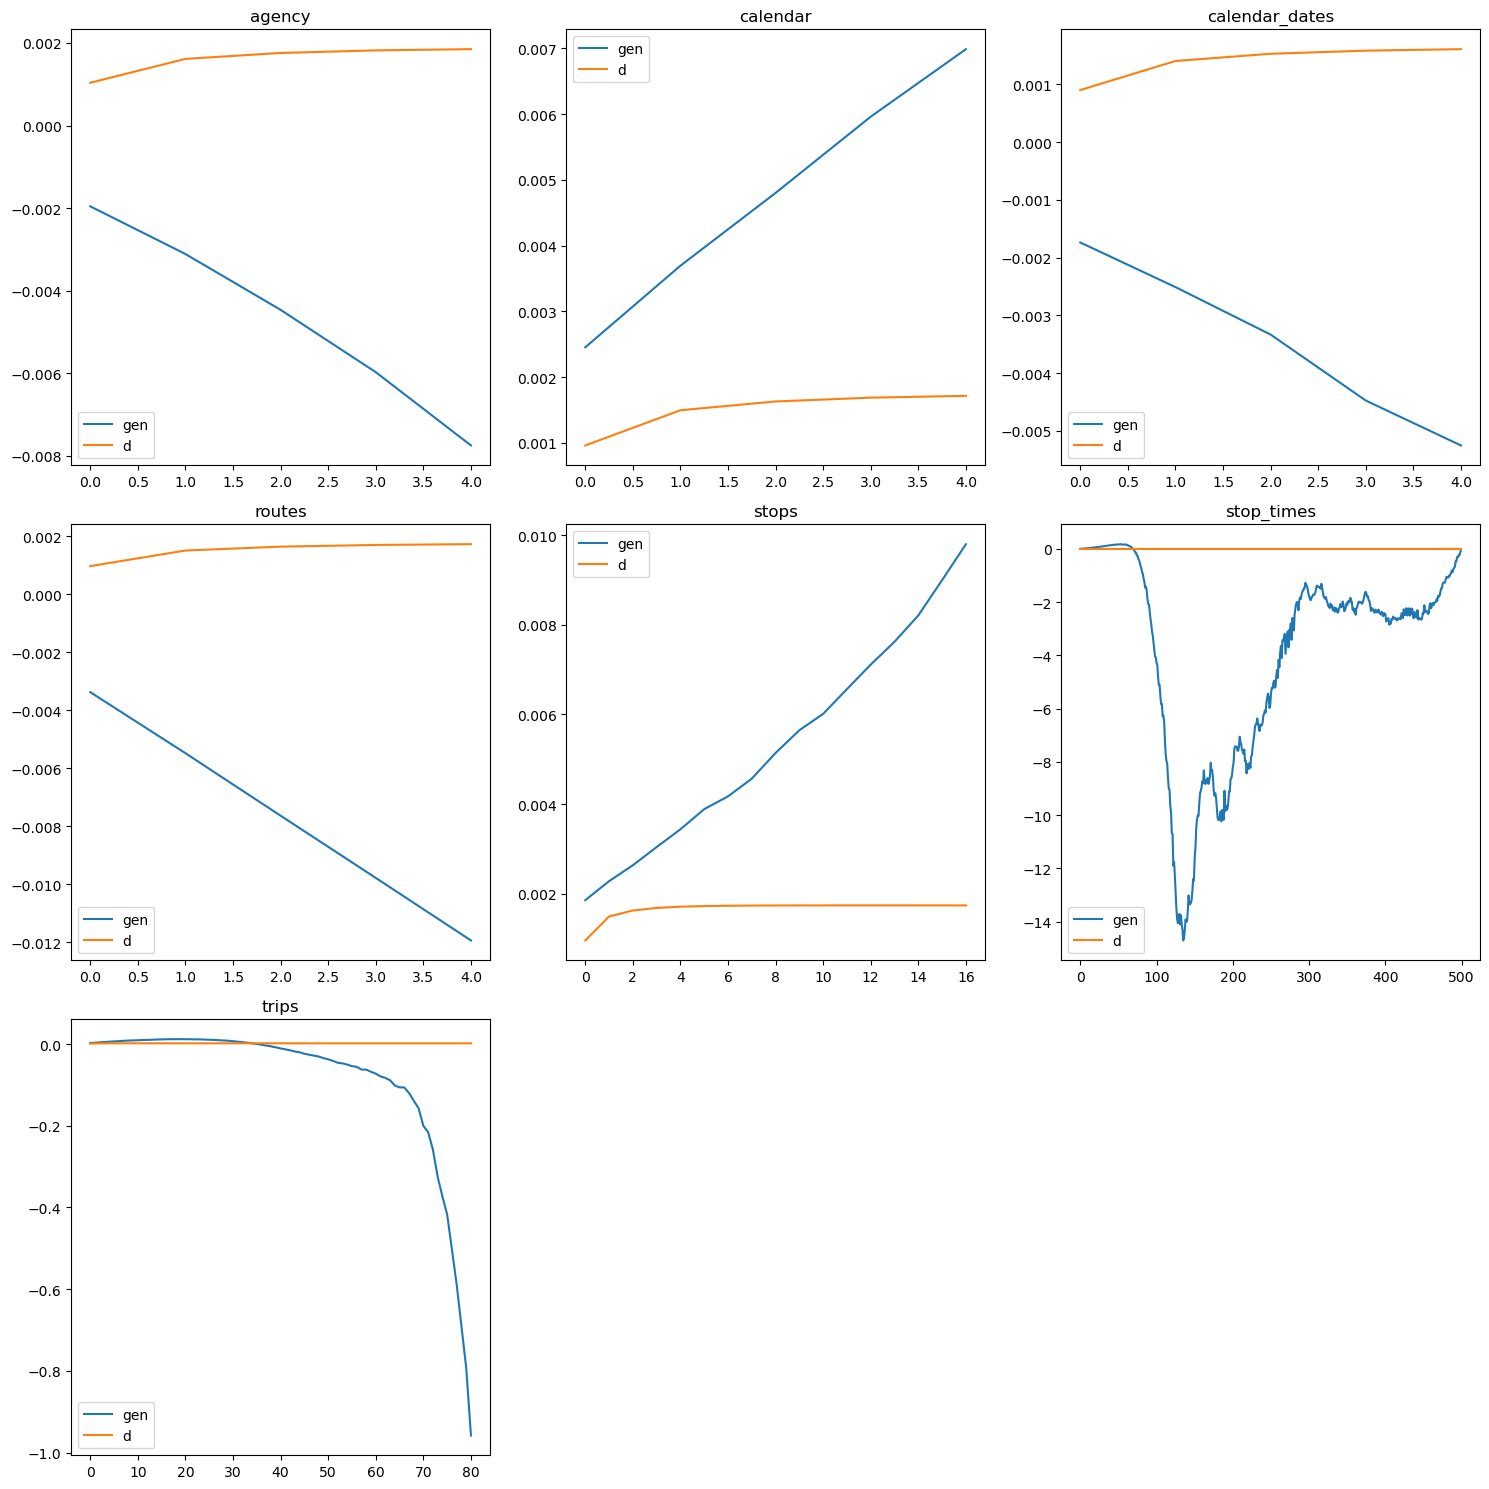

Total Time Used: 4m 10s
CPU times: total: 4min 53s
Wall time: 4min 10s


In [60]:
%%time

collection_training(processed_data_collection, modelling_metadata, training_parameter_dict)

# Synthetic Data Generation

In [61]:
def adjust_unique_elements(data, unique_elements, ignore=[]):
    for col, n_unique in unique_elements.items():
        if col not in ignore:
            data[col] = np.round(data[col]).astype(int)
            min_val, max_val = data[col].min(), data[col].max()
            original_range = np.linspace(min_val, max_val, n_unique)
            new_range = np.arange(n_unique)
            interp_func = interp1d(original_range, new_range, kind='nearest', bounds_error=False, fill_value=(0, n_unique - 1))
            data[col] = interp_func(data[col]).astype(int)
    return data

In [62]:
def generate_labels(kde, n_samples, col_names):
    new_data = kde.sample(n_samples)
    new_data_df = pd.DataFrame(new_data, columns=col_names)
    return new_data_df

In [63]:
def generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collections, transform_method_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    
    for df_name, content in modelling_metadata.items():
        if len(backtransformation_dict[df_name]['table_col_names']) != 0:
            generator = models.load_model('models/'+df_name+'_gen.h5')
        else:
            generator = None
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        n_samples = generation_dict[df_name]['nrows']
        
        fake_primary_key = None
        fake_selected_columns = None
        if primary_key != None:
            fake_primary_key = np.arange(n_samples)
            scaled_fake_primary_key = backtransformation_dict[df_name]['primary_key_scaler'].transform(fake_primary_key.reshape(-1, 1)).flatten()
            scaled_fake_primary_key = pd.DataFrame({primary_key:scaled_fake_primary_key})
            
        if content['selected_columns'] != []:
            kde = kde_collection[df_name]
            fake_selected_columns = generate_labels(kde, n_samples, content['selected_columns'])
        
        if fake_primary_key is not None:
            if fake_selected_columns is not None:
                raw_fake_labels = pd.concat([scaled_fake_primary_key, fake_selected_columns], axis=1)
            else:
                raw_fake_labels = scaled_fake_primary_key
        else:
            raw_fake_labels = fake_selected_columns
        
        raw_fake_labels = raw_fake_labels.reindex(columns=backtransformation_dict[df_name]['labels_col_names'])
        if content['is_sequential'] == True:
            raw_fake_labels = raw_fake_labels.sort_values(by=content['sort_order'])
        
        if generator is not None:
            latent_dim = 100
            noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
            raw_fake_table = generator.predict([noise, raw_fake_labels])
            fake_table = backtransformation_dict[df_name]['table_scaler'].inverse_transform(raw_fake_table)
            fake_table = pd.DataFrame(fake_table, columns=backtransformation_dict[df_name]['table_col_names'])
            fake_labels = backtransformation_dict[df_name]['labels_scaler'].inverse_transform(raw_fake_labels)
            fake_labels = pd.DataFrame(fake_labels,columns=backtransformation_dict[df_name]['labels_col_names'])
            unique_elements = backtransformation_dict[df_name]['unique_elements']
            if parent != None:
                # ignore = []
                for prnt, f_keys in parent.items():
                    unique_elements[f_keys] = generation_dict[prnt]['nrows']
                    # ignore.append(f_keys)
                fake_labels = adjust_unique_elements(fake_labels, unique_elements)
            else:
                fake_labels = adjust_unique_elements(fake_labels, unique_elements)
            fake_data = pd.concat([fake_labels, fake_table], axis=1)
            fake_subset = formatter_collections[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
        else:
            fake_labels = backtransformation_dict[df_name]['labels_scaler'].inverse_transform(raw_fake_labels)
            fake_data = pd.DataFrame(fake_labels,columns=backtransformation_dict[df_name]['labels_col_names'])
            unique_elements = backtransformation_dict[df_name]['unique_elements']
            if parent != None:
                # ignore = []
                for prnt, f_keys in parent.items():
                    unique_elements[f_keys] = generation_dict[prnt]['nrows']
                    # ignore.append(f_keys)
                fake_data = adjust_unique_elements(fake_data, unique_elements)
            else:
                fake_data = adjust_unique_elements(fake_data, unique_elements)
            fake_subset = formatter_collections[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
        fake_data = fake_data.reindex(columns=backtransformation_dict[df_name]['col_names'])
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [64]:
generation_dict = {k:{'nrows':len(v['labels'])} for k,v in processed_data_collection.items()}
generation_dict['calendar_dates']['sort_by'] = ['service_id','date']
generation_dict['stop_times']['sort_by'] = ['trip_id','stop_sequence']

In [65]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674, 'sort_by': ['service_id', 'date']},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790, 'sort_by': ['trip_id', 'stop_sequence']},
 'trips': {'nrows': 32403}}

In [66]:
%%time

synthetic_data_collection = generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collections, transform_method_dict)

C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\programs\conda\envs\tfgpu\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


CPU times: total: 1min 20s
Wall time: 1min 7s


In [67]:
def replace_keys_with_regex(dataframes, metadata):
    # Generate a mapping from old primary keys to new ones for each table
    primary_key_mappings = {}
    for table_name, table_info in metadata['tables'].items():
        df = dataframes[table_name]

        # Skip tables without a primary key
        if 'primary_key' not in table_info:
            continue

        primary_key = table_info['primary_key']

        # Skip columns without a regex_format
        if 'regex_format' not in table_info['columns'][primary_key]:
            continue

        regex = table_info['columns'][primary_key]['regex_format']

        # Generate new primary keys
        new_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Check if new keys are unique. If not, regenerate.
        while len(new_primary_keys) != len(set(new_primary_keys)):
            new_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Create a mapping from old primary keys to new ones
        primary_key_mappings[table_name] = dict(zip(df[primary_key], new_primary_keys))

        # Replace the primary keys in the original dataframe
        df[primary_key] = new_primary_keys

    # Update the foreign keys in each table
    for relationship in metadata['relationships']:
        parent_table_name = relationship['parent_table_name']
        child_table_name = relationship['child_table_name']
        child_foreign_key = relationship['child_foreign_key']

        # Get the mapping from old to new primary keys for the parent table
        key_mapping = primary_key_mappings.get(parent_table_name)

        # If there's no key mapping (i.e., the parent table has no primary key),
        # skip this relationship
        if key_mapping is None:
            continue

        # Replace the foreign keys in the child table
        dataframes[child_table_name][child_foreign_key] = dataframes[child_table_name][child_foreign_key].map(key_mapping)

    return dataframes

In [68]:
synthetic_data_collection = replace_keys_with_regex(synthetic_data_collection, sdv_metadata.to_dict())

In [69]:
synthetic_data_collection['stop_times'] = adjust_time(synthetic_data_collection['stop_times'], ['arrival_time','departure_time'])

In [70]:
# del processed_data_collection

In [71]:
with open('pkl/real_data_collection.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [72]:
# with open('pkl/synthetic_data_full_epoch.pkl', 'wb') as f:
#     pickle.dump(synthetic_data_collection, f)

In [73]:
with open('pkl/synthetic_data_10epoch.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [74]:
with open('pkl/modelling_metadata.pkl', 'wb') as f:
    pickle.dump(modelling_metadata, f)

In [75]:
with open('pkl/sdv_metadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)